In [2]:
from skimage import io, color, morphology
from skimage.util import img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage.filters import threshold_otsu
from skimage import segmentation
from skimage import measure
from skimage.color import label2rgb

In [3]:
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

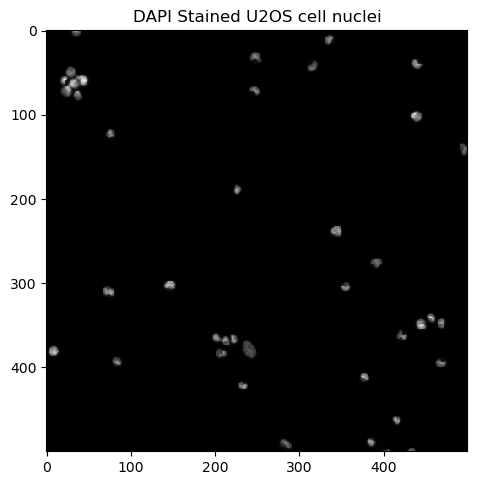

In [4]:
in_dir = "data/"
img_org = io.imread(in_dir + 'Sample E2 - U2OS DAPI channel.tiff')
# slice to extract smaller image
img_small = img_org[700:1200, 900:1400]
img_gray = img_as_ubyte(img_small) 
io.imshow(img_gray, vmin=0, vmax=150)
plt.title('DAPI Stained U2OS cell nuclei')
io.show()

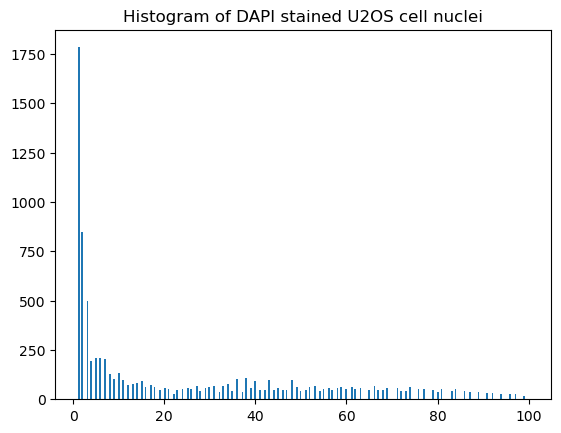

In [5]:
# avoid bin with value 0 due to the very large number of background pixels
plt.hist(img_gray.ravel(), bins=256, range=(1, 100))
plt.title('Histogram of DAPI stained U2OS cell nuclei')
io.show()

Threshold value =  30


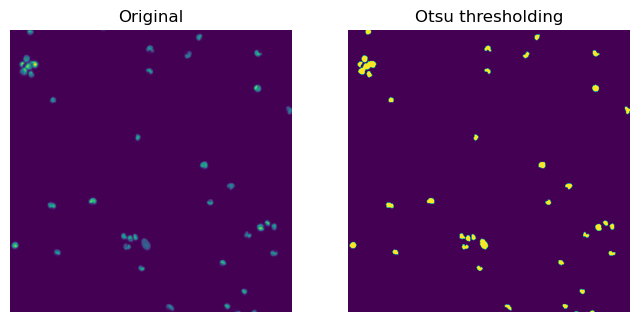

In [6]:
# Thresholding with Otsu's method
thresh = threshold_otsu(img_gray)
print('Threshold value = ', thresh)
img_bin = img_gray > thresh

# Show comparison
show_comparison(img_gray, img_bin, 'Otsu thresholding')

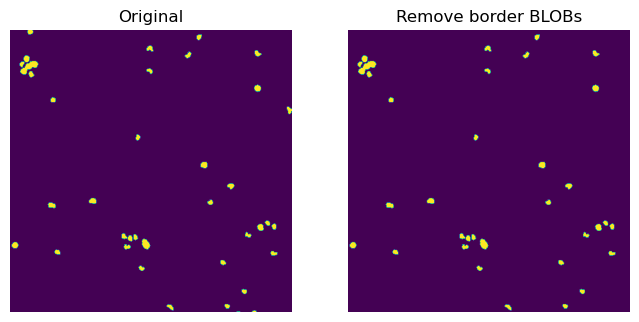

In [7]:
# Remove border BLOBs
img_borders = segmentation.clear_border(img_bin)

# Show comparison
show_comparison(img_bin, img_borders, 'Remove border BLOBs')

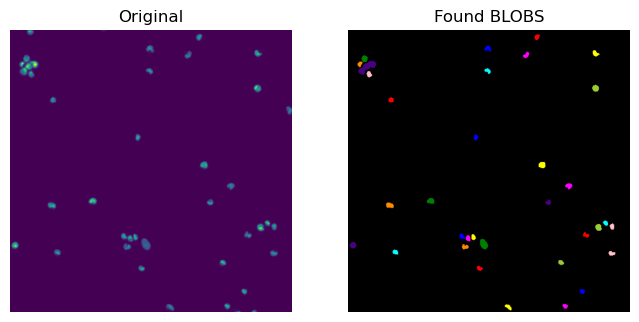

In [36]:
# Label BLOBs
label_img = measure.label(img_borders)
image_label_overlay = label2rgb(label_img)
show_comparison(img_gray, image_label_overlay, 'Found BLOBS')

In [37]:
# Blob features
region_props = measure.regionprops(label_img)
print('Number of BLOBs = ', len(region_props))
print('Area of BLOBs = ', [region.area for region in region_props])
print('Perimeter of BLOBs = ', [region.perimeter for region in region_props])

# Gather all the areas
areas = np.array([region.area for region in region_props])

Number of BLOBs =  34
Area of BLOBs =  [71, 88, 84, 78, 104, 360, 60, 68, 76, 115, 67, 63, 114, 93, 107, 66, 106, 61, 68, 111, 68, 73, 64, 71, 192, 103, 78, 69, 73, 68, 65, 63, 75, 60]
Perimeter of BLOBs =  [29.31370849898476, 38.384776310850235, 34.970562748477136, 34.79898987322333, 36.384776310850235, 93.84062043356595, 27.556349186104043, 31.556349186104047, 30.970562748477143, 38.384776310850235, 27.899494936611664, 28.14213562373095, 37.31370849898475, 35.79898987322333, 36.72792206135785, 30.14213562373095, 38.72792206135785, 26.727922061357855, 28.72792206135785, 36.970562748477136, 34.384776310850235, 32.14213562373095, 28.14213562373095, 29.31370849898476, 54.526911934581186, 34.970562748477136, 35.55634918610404, 29.899494936611664, 32.48528137423857, 28.727922061357855, 29.798989873223334, 27.31370849898476, 34.384776310850235, 27.313708498984763]


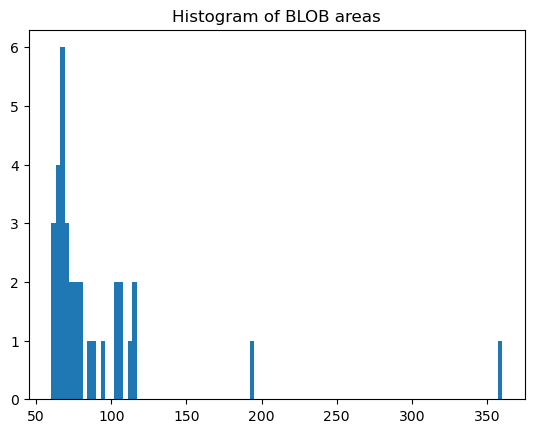

In [38]:
# Histogram of areas
plt.hist(areas, bins=100)
plt.title('Histogram of BLOB areas')
io.show()

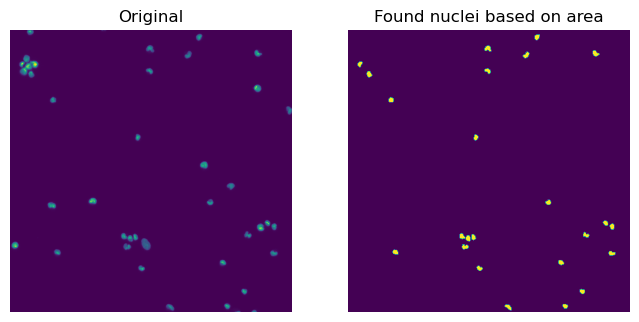

In [39]:
# Blob classification by area

min_area = 50
max_area = 90

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area')

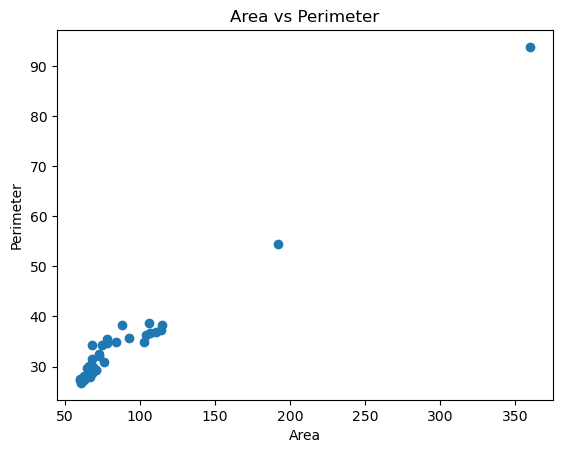

In [40]:
# Perimeter of BLOBs
perimeters = np.array([region.perimeter for region in region_props])

# Plot area vs perimeter
plt.scatter(areas, perimeters)
plt.title('Area vs Perimeter')
plt.xlabel('Area')
plt.ylabel('Perimeter')
io.show()

Circularity of BLOBs =  [1.03830915 0.75054115 0.8631453  0.80941489 0.9871969  0.51372491
 0.992928   0.85811456 0.99569256 0.98082082 1.08166302 0.99962316
 1.02891118 0.91190851 0.9967837  0.91286333 0.88811118 1.07302368
 1.03540522 1.02051812 0.72274712 0.88793927 1.0154902  1.03830915
 0.81150143 1.05838054 0.77530064 0.96990958 0.86927954 1.03540522
 0.91985661 1.06118004 0.79714756 1.01064766]


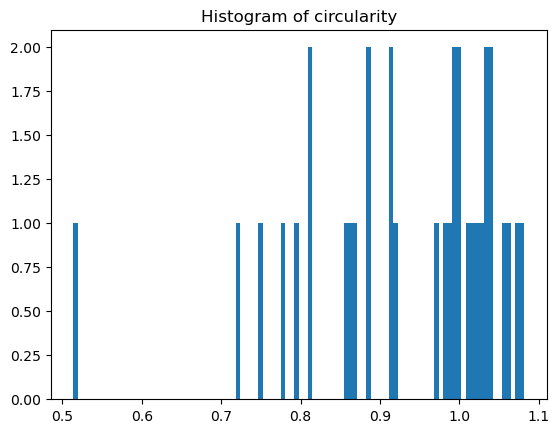

In [41]:
# Compute circularity
circularity = 4 * math.pi * areas / (perimeters ** 2)

# Add circularity to the region properties
for region, c in zip(region_props, circularity):
    region.circularity = c

# Gather all the circularities
circularity = np.array([region.circularity for region in region_props])
print('Circularity of BLOBs = ', circularity)

# Histogram of circularity
plt.hist(circularity, bins=100)
plt.title('Histogram of circularity')
io.show()


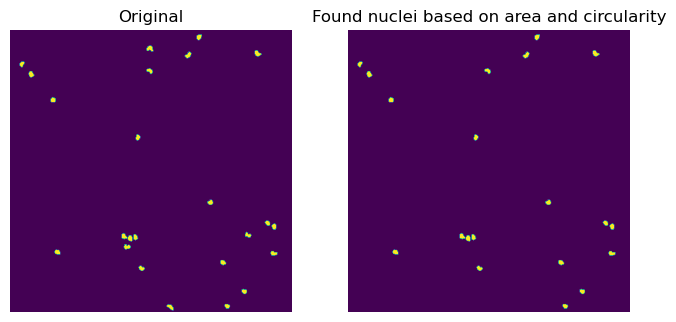

In [44]:
# Blob classification by circularity and area
# Area thresholds
min_area = 50
max_area = 90

# Circularity thresholds
min_circularity = 0.8
max_circularity = 1.1

# Create a copy of the label_img
label_img_filtered = label_img.copy()

for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filtered[cords[0], cords[1]] = 0
	# Find the circularities that do not fit our criteria
	elif region.circularity < min_circularity or region.circularity > max_circularity:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filtered[cords[0], cords[1]] = 0

# Create binary image from the filtered label image
i_area_circularity = label_img_filtered > 0
show_comparison(i_area, i_area_circularity, 'Found nuclei based on area and circularity')


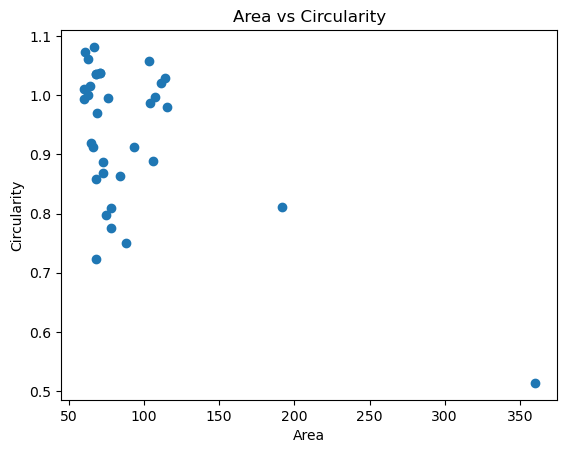

In [45]:
# Plot area vs circularity
plt.scatter(areas, circularity)
plt.title('Area vs Circularity')
plt.xlabel('Area')
plt.ylabel('Circularity')
io.show()
